In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
# from joblib import dump
import joblib
import warnings
import statsmodels.api as sm
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import wandb
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
style_dir='../../../styles'
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [4]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [5]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [7]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
from tabnet_keras import TabNetRegressor, TabNetClassifier
from tensorflow.keras.optimizers import Adam


tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "sparsemax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}

### Regression 
model = TabNetRegressor(n_regressors = 1, **tabnet_params)
lr=0.001
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])



In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [10]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler])

Epoch 1/10000
16982/16982 [==============================] - 412s 21ms/step - loss: 0.1985 - mae: 0.1977 - r2: 0.2719 - val_loss: 0.3605 - val_mae: 0.3601 - val_r2: -2.4512 - lr: 0.0010
Epoch 2/10000
16982/16982 [==============================] - 361s 21ms/step - loss: 0.1507 - mae: 0.1501 - r2: 0.4729 - val_loss: 0.2147 - val_mae: 0.2142 - val_r2: 0.5521 - lr: 0.0010
Epoch 3/10000
16982/16982 [==============================] - 364s 21ms/step - loss: 0.1450 - mae: 0.1445 - r2: 0.5162 - val_loss: 0.2544 - val_mae: 0.2539 - val_r2: 0.3661 - lr: 0.0010
Epoch 4/10000
16982/16982 [==============================] - 366s 22ms/step - loss: 0.1409 - mae: 0.1404 - r2: 0.5347 - val_loss: 0.2096 - val_mae: 0.2092 - val_r2: 0.6238 - lr: 0.0010
Epoch 5/10000
16982/16982 [==============================] - 366s 22ms/step - loss: 0.1363 - mae: 0.1358 - r2: 0.5528 - val_loss: 0.2014 - val_mae: 0.2010 - val_r2: 0.6582 - lr: 0.0010
Epoch 6/10000
16982/16982 [==============================] - 368s 22ms/ste

In [12]:
model.summary()
model.save_weights('tabnet.h5')

Model: "tab_net_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  35584     
 oder)                                                           
                                                                 
 regressor (Dense)           multiple                  16        
                                                                 
Total params: 35600 (139.06 KB)
Trainable params: 32736 (127.88 KB)
Non-trainable params: 2864 (11.19 KB)
_________________________________________________________________


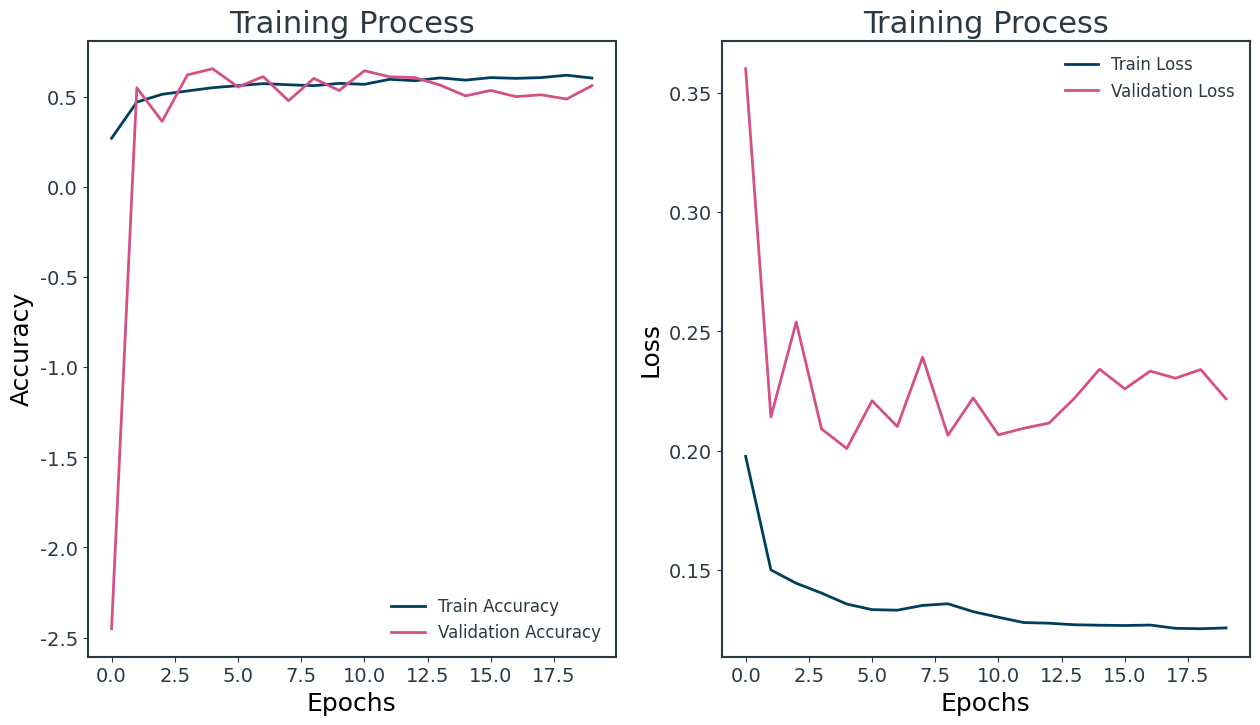

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [14]:
model.history.history['r2']

[0.27194762229919434,
 0.47287267446517944,
 0.5161891579627991,
 0.5347470045089722,
 0.5528168082237244,
 0.56423020362854,
 0.57548588514328,
 0.5691510438919067,
 0.5640886425971985,
 0.5766270756721497,
 0.5715842247009277,
 0.5992695093154907,
 0.5916095972061157,
 0.6073131561279297,
 0.5948433876037598,
 0.6088154315948486,
 0.6047094464302063,
 0.6089568734169006,
 0.6220775246620178,
 0.6063583493232727]

In [15]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.19846110045909882, 0.1506781131029129, 0.14503884315490723, 0.14088913798332214, 0.13626974821090698, 0.13389122486114502, 0.13364478945732117, 0.1356339454650879, 0.13632315397262573, 0.13298597931861877, 0.13055947422981262, 0.12834112346172333, 0.12806017696857452, 0.12738826870918274, 0.12714919447898865, 0.12701527774333954, 0.12719395756721497, 0.1258331835269928, 0.12566787004470825, 0.12600423395633698]
[0.36052602529525757, 0.2147107720375061, 0.2544461190700531, 0.20962560176849365, 0.20141763985157013, 0.22142954170703888, 0.2106417417526245, 0.23966971039772034, 0.20693296194076538, 0.22250473499298096, 0.20699015259742737, 0.20980095863342285, 0.21188363432884216, 0.222132608294487, 0.2343382090330124, 0.2260902225971222, 0.23355484008789062, 0.23057471215724945, 0.2342199683189392, 0.2219250500202179]


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 [==============================] - 33s 2ms/step
R2 Score: 0.724737387107564
MAE: 0.20096921997814485
